In [2]:
import os 
import zipfile
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil

## Data Extraction

In [2]:
# Paths to the zip files
zip_files = {
    'Dataset-zip/annotation.zip': './Dataset-org/annotation',
    'Dataset-zip/images.zip': './Dataset-org/images'
}

# Create necessary directories and extract files
for zip_file_path, target_folder in zip_files.items():
    # Create the target folder if it doesn't exist
    os.makedirs(target_folder, exist_ok=True)
    
    # Extract the files
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(target_folder)
        print(f"Extracted {zip_file_path} to {target_folder}")

print("All files extracted successfully.")

Extracted Dataset-zip/annotation.zip to ./Dataset-org/annotation
Extracted Dataset-zip/images.zip to ./Dataset-org/images
All files extracted successfully.


## Data Preprocessing
### Correction of path Tag on Annotation files

In [3]:
# Base directory containing annotation folders
annotation_dir = './Dataset-org/annotation'

# New base path to replace the <path> tag
new_base_path = r'D:\AI Client project PR-0019\Dataset-org\images\content\images'

# Iterate through all folders and XML files in the annotation directory
for root, _, files in os.walk(annotation_dir):
    for file in files:
        if file.endswith('.xml'):  # Process only XML files
            xml_file_path = os.path.join(root, file)

            try:
                # Parse the XML file
                tree = ET.parse(xml_file_path)
                root_element = tree.getroot()

                # Find and update the <path> tag
                for path_tag in root_element.iter('path'):
                    # Extract the file name from the existing path
                    file_name = os.path.basename(path_tag.text)
                    # Create the new path
                    new_path = os.path.join(new_base_path, file_name)
                    # Update the <path> tag
                    path_tag.text = new_path

                # Save the updated XML file
                tree.write(xml_file_path, encoding='utf-8', xml_declaration=True)

            except ET.ParseError:
                print(f"Skipping malformed or empty XML file: {xml_file_path}")
            except Exception as e:
                print(f"Error processing file {xml_file_path}: {e}")

print("Processing complete.")

Processing complete.


### Total Annotations And Images

In [4]:
# Paths
annotation_dir = './Dataset-org/annotation'
images_dir = './Dataset-org/images/content/images'

def count_files(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count files in annotation and images directories
annotation_file_count = count_files(annotation_dir)
images_file_count = count_files(images_dir)

print(f"Total files in 'annotation': {annotation_file_count}")
print(f"Total files in 'images': {images_file_count}")

Total files in 'annotation': 2122
Total files in 'images': 1933


### Extra Annotation And Images Are Removed

In [ ]:
# Paths to annotation and images directories
annotation_dir = Path('./Dataset-org/annotation')
images_dir = Path('./Dataset-org/images/content/images')

# Collect all image and annotation file names (without extensions)
image_files = set(f.stem for f in images_dir.rglob('*') if f.is_file())
annotation_files = set(f.stem for f in annotation_dir.rglob('*.xml') if f.is_file())

# Find files that are not matched (extra files)
extra_annotations = annotation_files - image_files  # Annotations without corresponding images
extra_images = image_files - annotation_files      # Images without corresponding annotations

# Collect the files to delete
files_to_delete = []

# Delete extra annotation files (those that don't have a corresponding image)
for annotation_file in annotation_dir.rglob('*.xml'):
    if annotation_file.stem in extra_annotations:
        print(f"Deleting extra annotation: {annotation_file}")
        files_to_delete.append(str(annotation_file))
        annotation_file.unlink()  # Delete the file

# Delete extra image files (those that don't have a corresponding annotation)
for image_file in images_dir.rglob('*.*'):
    if image_file.stem in extra_images:
        print(f"Deleting extra image: {image_file}")
        files_to_delete.append(str(image_file))
        image_file.unlink()  # Delete the file

# Log deleted files (optional)
with open('deleted_files.log', 'w') as log_file:
    log_file.write('\n'.join(files_to_delete))

print(f"Deleted {len(files_to_delete)} extra files (images and annotations).")


Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-1.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-3.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-4.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01872-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01872-3.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01873-1.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01873-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01873-3.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01875-1.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01875-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01875-3.xml
Deleting extra annotation: D

In [7]:
# Paths
annotation_dir = './Dataset-org/annotation'
images_dir = './Dataset-org/images/content/images'

def count_files(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count files in annotation and images directories
annotation_file_count = count_files(annotation_dir)
images_file_count = count_files(images_dir)

print(f"Total files in 'annotation': {annotation_file_count}")
print(f"Total files in 'images': {images_file_count}")

Total files in 'annotation': 1915
Total files in 'images': 1915


### Correction Of name Tag Details On Annotation Files 

In [ ]:
# Paths
annotation_dir = './Dataset-org/annotation'

# Class mapping based on subdirectory names
class_mapping = {
    "asiatic rice borer": 1,
    "paddy stem maggot": 2,
    "rice gall midge": 3,
    "rice leaf caterpillar": 4,
    "rice leaf roller": 5,
    "small brown plant hopper": 6,
    "wheat blossom midge": 7,
    "wheat phloeothrips": 8,
    "wheat sawfly": 9,
    "white backed plant hopper": 10,
    "yellow rice borer": 11
}

# Update annotations
def update_annotations(annotation_dir):
    for class_name in os.listdir(annotation_dir):
        class_path = os.path.join(annotation_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".xml"):
                    file_path = os.path.join(class_path, file)
                    try:
                        # Parse XML
                        tree = ET.parse(file_path)
                        root = tree.getroot()

                        # Update or add <name> tag
                        updated = False
                        for obj in root.findall("object"):
                            name_tag = obj.find("name")
                            if name_tag is None:
                                # Add <name> tag if missing
                                name_tag = ET.SubElement(obj, "name")
                                updated = True
                            # Update <name> with the correct class name
                            if name_tag.text != class_name:
                                name_tag.text = class_name
                                updated = True

                        # Save the updated XML file
                        if updated:
                            tree.write(file_path)
                    except ET.ParseError:
                        print(f"Invalid XML file skipped: {file_path}")

# updating annotation
update_annotations(annotation_dir)
print("update on annotation files name tag is done")

update on annotation files name tag is done


## Visualization 

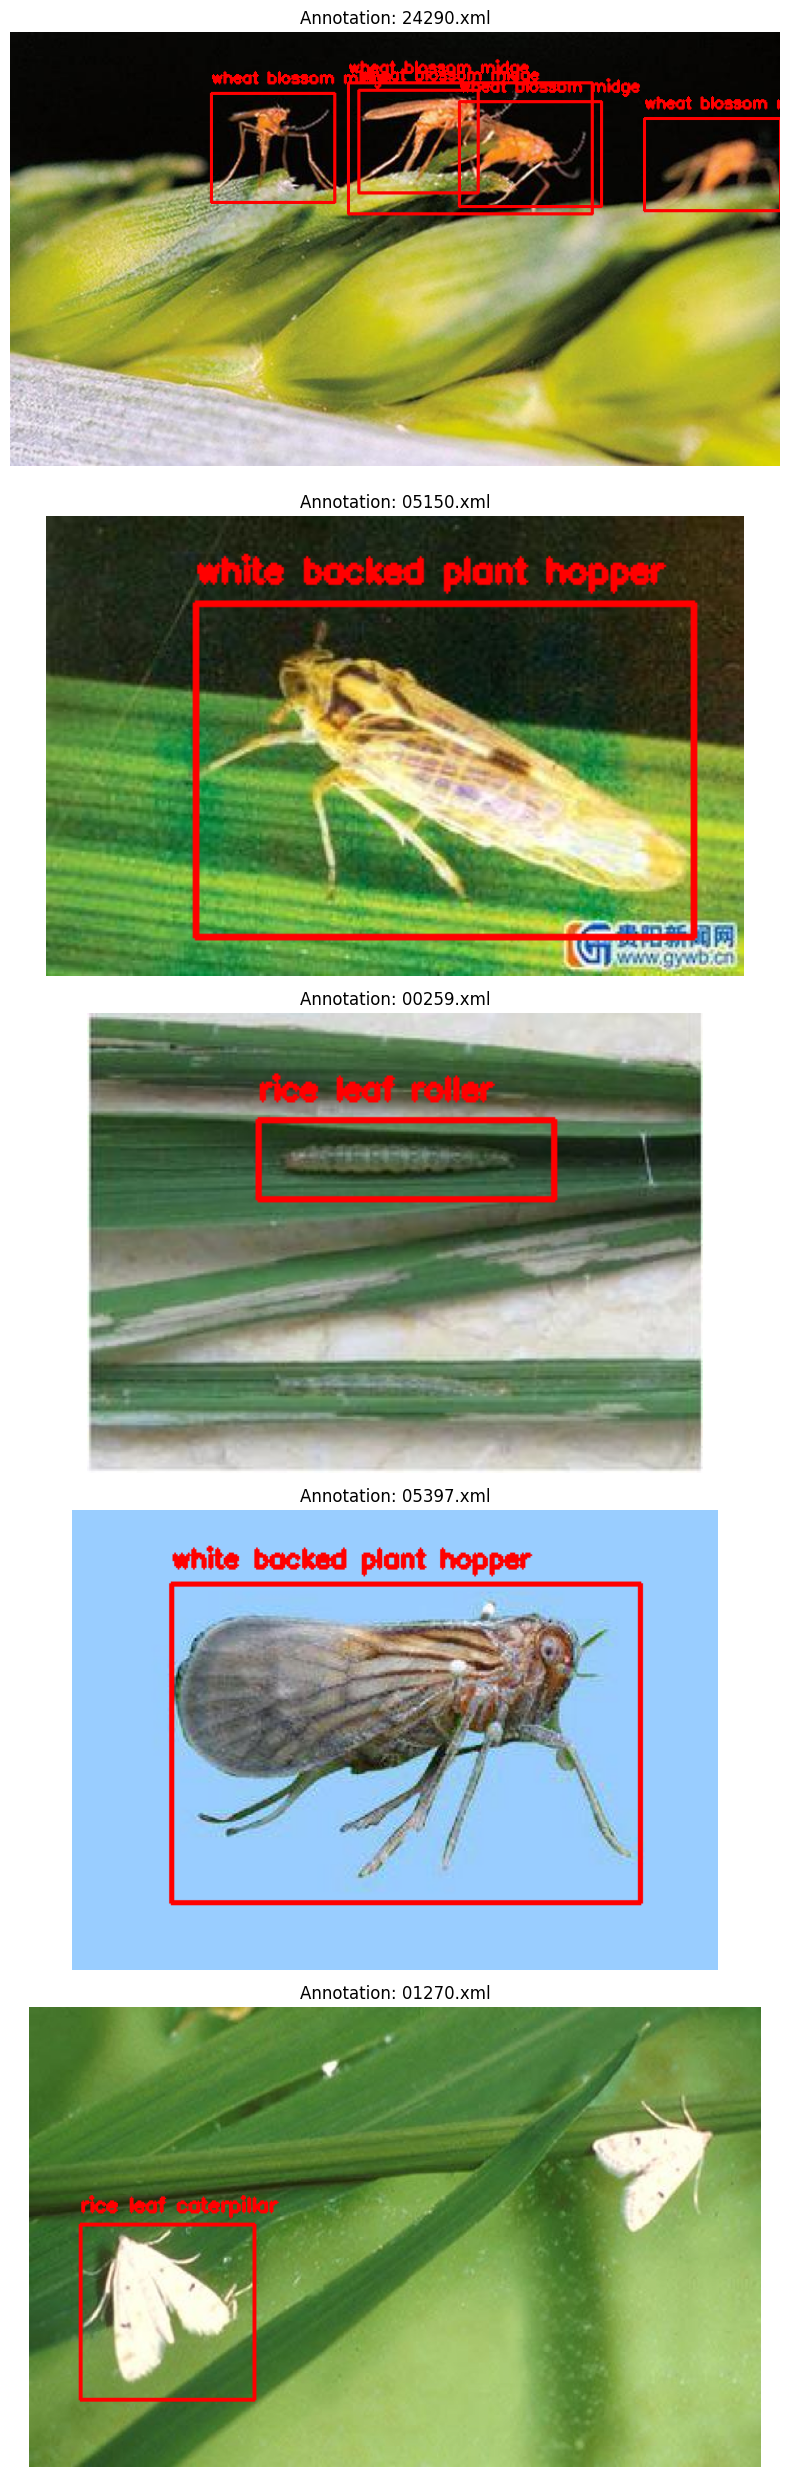

In [13]:
# Paths
annotation_folder = './Dataset-org/annotation'
image_folder = './Dataset-org/images/content/images'

def visualize_random_annotations(annotation_folder, image_folder, num_images=5):
    # Get all XML files
    xml_files = []
    for root, _, files in os.walk(annotation_folder):
        for file in files:
            if file.endswith('.xml'):
                xml_files.append(os.path.join(root, file))

    # Randomly select XML files
    selected_files = random.sample(xml_files, min(num_images, len(xml_files)))

    # Create a figure for displaying images vertically
    fig, axes = plt.subplots(len(selected_files), 1, figsize=(8, 5 * len(selected_files)))

    if len(selected_files) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image

    for i, xml_file in enumerate(selected_files):
        # Parse the XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get image file name
        filename = root.find('filename').text
        image_path = os.path.join(image_folder, filename)

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            continue

        # Convert BGR (OpenCV) to RGB (Matplotlib)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Draw the bounding box
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            # Put label text
            cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display the image with annotations
        axes[i].imshow(image)
        axes[i].set_title(f"Annotation: {os.path.basename(xml_file)}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 5 random annotated images
visualize_random_annotations(annotation_folder, image_folder, num_images=5)


## Creation Of Masks For Entire Dataset

In [14]:
# Paths
annotation_dir = './Dataset-org/annotation'
images_dir = './Dataset-org/images/content/images'
masks_dir = './Dataset-org/masks'  # Directory to save generated masks
os.makedirs(masks_dir, exist_ok=True)


def create_mask(image_path, annotation_path, mask_path, class_mapping):
    # Read the image to get dimensions
    image = cv2.imread(image_path)
    if image is None:
        print(f"Unable to read image: {image_path}")
        return
    height, width = image.shape[:2]

    # Create an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)

    try:
        # Parse annotation XML
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        annotations_found = False  # Flag to check if any annotations were processed

        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name in class_mapping:
                class_id = class_mapping[class_name]
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                # Draw rectangle on mask
                cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), class_id, -1)  # Fill rectangle with class_id
                annotations_found = True

        if not annotations_found:
            print(f"No annotations found in {annotation_path}")

    except ET.ParseError:
        print(f"Invalid XML file: {annotation_path}")
        return

    # Save the mask
    os.makedirs(os.path.dirname(mask_path), exist_ok=True)
    cv2.imwrite(mask_path, mask)

# Process all images and annotations
for class_dir in os.listdir(annotation_dir):
    class_annotation_dir = os.path.join(annotation_dir, class_dir)
    if os.path.isdir(class_annotation_dir):
        class_image_dir = os.path.join(masks_dir, class_dir)
        os.makedirs(class_image_dir, exist_ok=True)

        for annotation_file in os.listdir(class_annotation_dir):
            annotation_path = os.path.join(class_annotation_dir, annotation_file)
            image_name = annotation_file.replace(".xml", ".jpg")
            image_path = os.path.join(images_dir, image_name)
            mask_path = os.path.join(class_image_dir, annotation_file.replace(".xml", ".png"))


            # Check if files exist
            if not os.path.exists(annotation_path):
                print(f"Annotation file not found: {annotation_path}")
                continue

            if not os.path.exists(image_path):
                print(f"Image file not found: {image_path}")
                continue

            # Create mask
            create_mask(image_path, annotation_path, mask_path, class_mapping)
            
print("masks generated")

masks generated


## Visualization Of A Mask And Related Image

Loaded image from ./Dataset-org/images/content/images/01871.jpg
Loaded mask from ./Dataset-org/masks/asiatic rice borer/01871.png


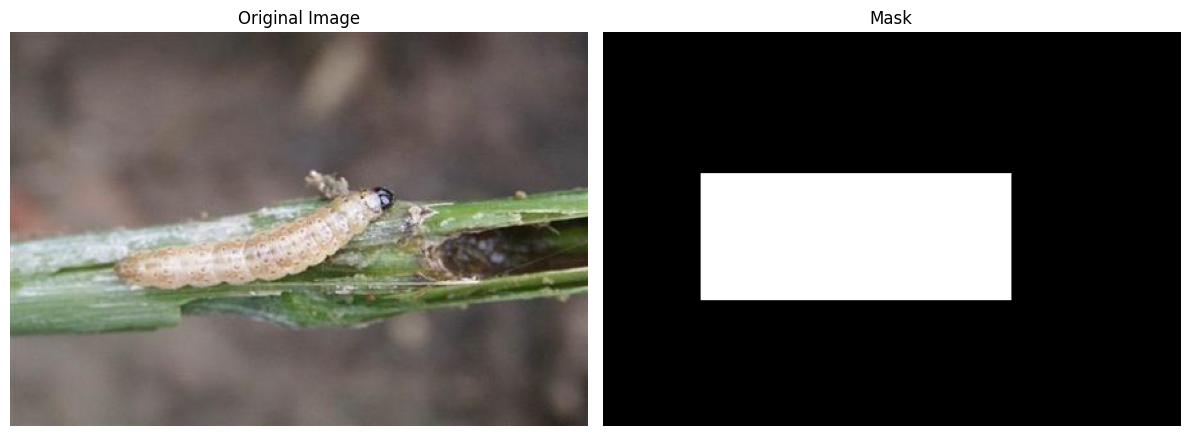

In [22]:
# Paths for the image and mask
image_path = './Dataset-org/images/content/images/01871.jpg'  
mask_path = './Dataset-org/masks/asiatic rice borer/01871.png' 

# Read the image and mask
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

# Check if the image and mask are loaded correctly
if image is None:
    print(f"Error loading image from {image_path}")
else:
    print(f"Loaded image from {image_path}")

if mask is None:
    print(f"Error loading mask from {mask_path}")
else:
    print(f"Loaded mask from {mask_path}")

# Convert BGR (OpenCV) to RGB (Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Visualize the image and mask side by side
plt.figure(figsize=(12, 6))

# Plot the original image on the left
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')  # Hide axis

# Plot the mask on the right
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

## Train, Test And Validation Split

In [10]:
# Paths
base_dir = './Dataset-org'
images_dir = os.path.join(base_dir, 'images', 'content', 'images')  # Path to images
masks_dir = os.path.join(base_dir, 'masks')
annotations_dir = os.path.join(base_dir, 'annotation')

output_base_dir = './Dataset-split'
output_images_dir = os.path.join(output_base_dir, 'images')
output_masks_dir = os.path.join(output_base_dir, 'masks')
output_annotations_dir = os.path.join(output_base_dir, 'annotations')

# Create output directories for each split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(output_masks_dir, split), exist_ok=True)
    os.makedirs(os.path.join(output_annotations_dir, split), exist_ok=True)

# Collect image, mask, and annotation paths
dataset = []

# Iterate through the annotation directory and match the class with images
for class_name in os.listdir(annotations_dir):
    annotation_class_dir = os.path.join(annotations_dir, class_name)
    mask_class_dir = os.path.join(masks_dir, class_name)

    if not os.path.isdir(annotation_class_dir) or not os.path.isdir(mask_class_dir):
        continue  # Skip if not a directory

    # Get all annotation files in the class directory
    for annotation_file in os.listdir(annotation_class_dir):
        if annotation_file.endswith('.xml'):
            base_name = os.path.splitext(annotation_file)[0]  # Get the file name without extension
            image_file = f"{base_name}.jpg"
            mask_file = f"{base_name}.png"

            # Paths to the image, mask, and annotation
            image_path = os.path.join(images_dir, image_file)
            mask_path = os.path.join(mask_class_dir, mask_file)
            annotation_path = os.path.join(annotation_class_dir, annotation_file)

            # Ensure all files exist
            if os.path.exists(image_path) and os.path.exists(mask_path) and os.path.exists(annotation_path):
                dataset.append((image_path, mask_path, annotation_path, class_name))

# Split dataset into train, val, and test by class
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Helper function to copy files
def copy_files(data, split):
    for image_path, mask_path, annotation_path, class_name in data:
        # Create subdirectory for the class in the split (train, val, test)
        class_image_dir = os.path.join(output_images_dir, split, class_name)
        os.makedirs(class_image_dir, exist_ok=True)

        # Copy image
        dst_image = os.path.join(class_image_dir, os.path.basename(image_path))
        shutil.copy(image_path, dst_image)

        # Copy mask
        dst_mask = os.path.join(output_masks_dir, split, class_name, os.path.basename(mask_path))
        os.makedirs(os.path.dirname(dst_mask), exist_ok=True)
        shutil.copy(mask_path, dst_mask)

        # Copy annotation
        dst_annotation = os.path.join(output_annotations_dir, split, class_name, os.path.basename(annotation_path))
        os.makedirs(os.path.dirname(dst_annotation), exist_ok=True)
        shutil.copy(annotation_path, dst_annotation)

# Copy files for each split (train, val, test)
copy_files(train_data, 'train')
copy_files(val_data, 'val')
copy_files(test_data, 'test')

print("Dataset split completed with class-based subdirectories for images")

Dataset split completed with class-based subdirectories for images
